# Фильтр Калмана
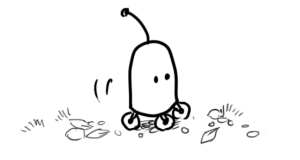

```{https://www.base64-image.de/}
```

## Рассмотрим задачу
Пусть у нас есть радиоуправляемая машинка (робот), которая движется равноускоренно по некоторой траектории. Для простоты предположим, что машинка может ехать только вперед / назад со скоростью $v_k$ в момент времени $k$. На машинке также установлен GPS-датчик, который производит измерение $z_k$ в каждый момент времени $k$ и сообщает нам информацию о координатах машинки $p_k$ с некоторой неточностью (погрешностью измерений).
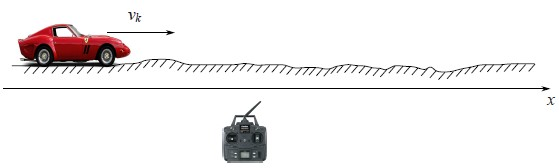

Из базовой кинематики [известно](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B2%D0%BD%D0%BE%D1%83%D1%81%D0%BA%D0%BE%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B2%D0%B8%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5), что равноускоренное движение можно описать как:
\begin{equation}
x_t=x_0+{v_0}t + \frac{at^2}{2}.
\end{equation}

___

### Моделирование измерений датчика (одномерный случай)

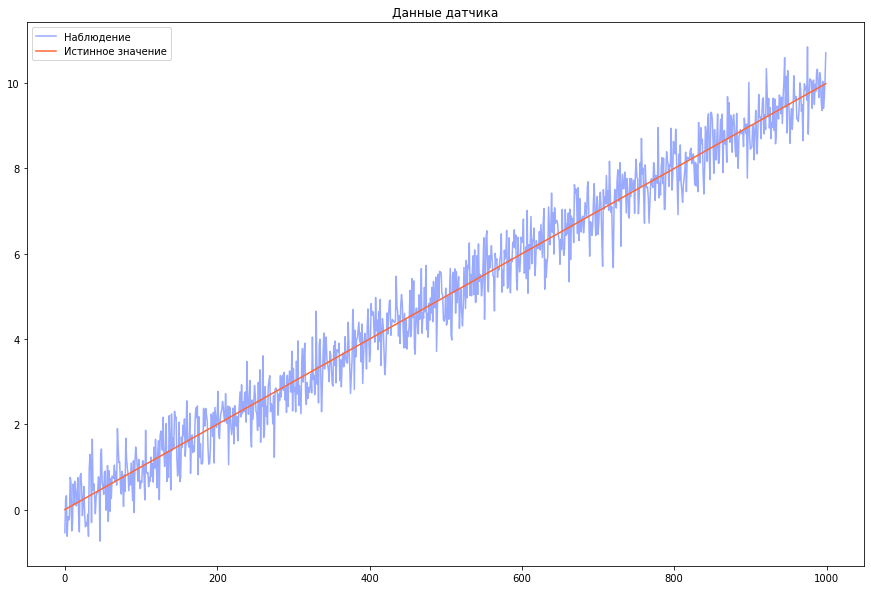

In [4]:
import numpy as np
import numpy.random

def simulate_sensor(num_samples, noise_sigma, dt):
    '''
    Моделирует измерения датчика (одномерный случай).
    '''
    
    # Генерируем шум с нормальным распределением
    # (мат. ожидание = 0, среднеквадр. отклонение = noise_sigma):
    noise = np.random.normal(loc=0.0, scale=noise_sigma, size=num_samples)

    # Опишем траекторию движения при помощи 2 компонент (положение и скорость):
    trajectory = np.zeros((2, num_samples))
    position = 0
    velocity = 1.0                          # равноускоренное движение
    acceleration = 0.0

    # Применяем формулу равноускоренного движения:
    for i in range(1, num_samples):
        position = position + velocity * dt + (acceleration * dt ** 2) / 2.0
        velocity = velocity + acceleration * dt
        acceleration = acceleration

        trajectory[0][i] = position
        trajectory[1][i] = velocity

    # Добавляем шум к измерениям датчика:
    measurements = trajectory[0] + noise

    return trajectory, measurements         # истинное значение и данные датчика с шумом



### Визуализируем результаты моделирования ###
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

trajectory, measurements = simulate_sensor(num_samples=1000, noise_sigma=0.5, dt=0.01)

plt.title("Данные датчика")
plt.plot(measurements, label="Наблюдение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.legend()
plt.show()

___

### Как отфильтровать истинные значения наблюдений?
<details>
<summary> &#9658; При помощи...</summary>
...фильтра Калмана!
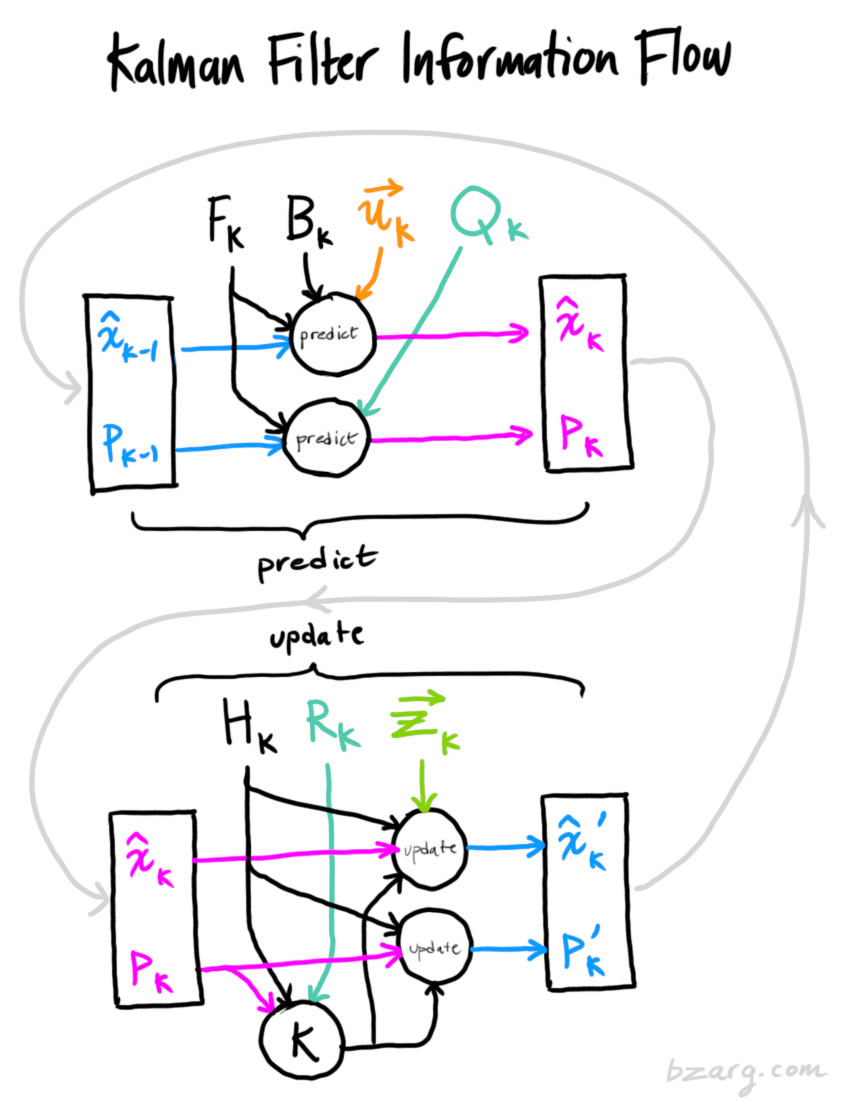
</details>

## Фильтр Калмана

*Фильтр Калмана* - инструмент фильтрации данных. В процессе фильтрации используется информация о самой физике протекающего процесса.

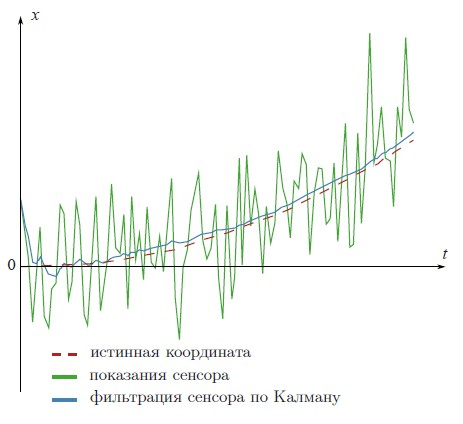

<ins>*Для работы фильтра Калмана необходимо:*</ins>
1. Модель системы / процесса.
2. Модель должна быть линейной (однако, с нелинейными системами умеет работать *расширенный фильтр Калмана*)!
3. Модель должна быть дискретной (измерения и вычисления происходят в дискретные моменты времени)
4. Вектор, описывающий состояние системы в определенный момент времени (координата, скорость, температура и т.п.)
5. Модель наблюдения (датчик/сенсор/спидометр и т.п.)
6. Алгоритм работает итеративно, поэтому на каждом шаге ему достаточно знать данные измерения на текущем шаге и результаты вычислений на предыдущем шаге.
7. Алгоритм может работать как в реалтайме (online mode), так и на основе всех данных (batch mode).


### Prediction step
В *фазе предсказания* оценивается вектор состояния системы в момент времени $t$ на основе состояния в момент $t-1$.

$\vec{x_k}=\begin{bmatrix} p \\ v \end{bmatrix}$ - вектор состояния системы (*state mean*) в момент времени $k$ может определяться, например, позицией и скоростью.

$P_k=\begin{bmatrix} \Sigma_{pp}&\Sigma_{pv} \\ \Sigma_{vp}&\Sigma_{vv} \end{bmatrix}$ - мера неопределенности вектора состояния (*transition covariance*), представляет из себя ковариационную матрицу.

$F_k=\begin{bmatrix} 1&dt&dt^2/2 \\ 0&1&dt \\ 0&0&1 \end{bmatrix}$ - матрица процесса (*state transition matrix*), описывает как получить новое состояние системы из предыдущего.

$B_k$, $\vec{u_k}$ - матрица управления (*control matrix / transition offset*) и вектор управления (*control vector*), соответственно. Используются, если мы напрямую управляем процессом (например, движением с пульта). Если только наблюдаем - можно опустить.

$Q_k$ - ковариционная матрица ошибки, описывает неопределенность системы из-за шума (неровность дороги, неучтенные силы и т.п.). Чем выше значения матрицы, тем меньше мы доверяем предсказаниям, и больше - измерениям.


<ins>Таким образом, состояние системы в момент времени $t$ предсказывается как</ins>:
\begin{equation}
\hat{x}_t=F_k \hat{x}_{k-1}+B_k \vec{u_k}\\
P_k=F_k P_{k-1} F^T_k + Q_k
\end{equation}


### Update step
В этой фазе происходит коррекция предсказанного состояния на основе данных наблюдения.

$H_k = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$ - матрица наблюдения (*observation matrix*). Столбцы соответствуют  датчикам (сколько датчиков - столько столбцов), строки - вектору состояния (в данном случае $\begin{bmatrix} 1 \\ 0 \end{bmatrix}$ указывает на то, что у нас один датчик, который измеряет только позицию, но не скорость).

$\vec{z}_k$ - значения измерений датчиком (*measurements*) в момент времени $t$.

$R_k=\begin{bmatrix} \sigma^2 \end{bmatrix}$ - ковариционная матрица погрешности измерений (*observation covariance*). Обычно измерения не коррелируют между собой, поэтому используется только дисперсия. Чем значение этой матрицы больше, тем меньше алгоритм будет "доверять" измерениям, и больше предсказаниям. В данном случае мы измеряем только позицию, поэтому матрица содержит ровно один элемент. 

$K$ - коэффициент усиления Калмана (*Kalman gain*).

<ins>Таким образом, предсказанное состояние корректируется следующим образом</ins>:
$$
\hat{x}^{'}_t=\hat{x}_t + K^{'}(\vec{z}_k - H_k \hat{x}_k)\\
P^{'}_k = P_k - K^{'} H_k P_k\\
K^{'} = P_k H^{T}_k (H_k P_K H^{T}_k + R_k)^{-1}
$$

___

# Установка пакета pykalman
Пакет **pykalman** содержит реализацию *Kalman Filter*, *Kalman Smoother*, и *EM-алгоритма* на Python.

pykalman github: https://github.com/pykalman/pykalman 

documentation: https://pykalman.github.io/

Можно установить через pip: ```pip install pykalman```

## Применяем фильтр Калмана (одномерный случай)

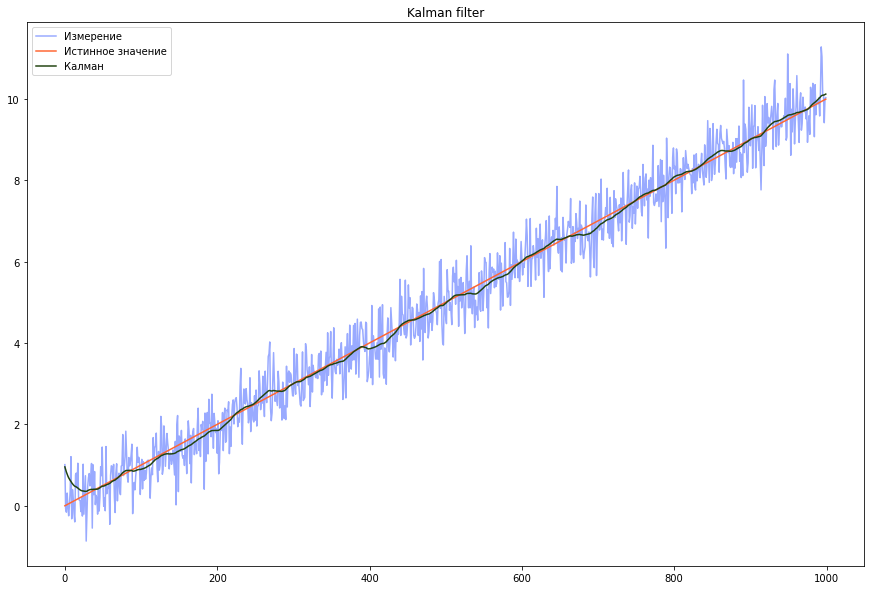

In [5]:
import numpy as np
# %pip install pykalman                               # устанавливаем pykalman
from pykalman import KalmanFilter


def apply_kalman(measurements, dt=0.01):
    '''
    Применяет фильтр Калмана к заданным измерениям.
    '''
    # Начальное состояние модели:
    initial_state_mean = [measurements[0][0], 0, 0]       # начальное состояние: позиция, скорость и ускорение

    # Матрица процесса (state transition matrix):
    transition_mat = [[1, dt, (dt**2)/2],
                      [0,  1,        dt],
                      [0,  0,         1]]

    # Матрица наблюдения (obervation matrix):
    observation_mat = [[1.0, 0.0, 0.0]]                    # датчик измеряет только позицию
    
    # Матрица ковариации наблюдения:
    observation_cov = np.array([[10*10]])                  # чем значение больше, тем меньше доверяем датчику

    # Создаем фильтр Калмана с заданными матрицами 
    # процесса, наблюдения и начальным состоянием:
    kf1 = KalmanFilter(transition_matrices=transition_mat,
                       observation_matrices=observation_mat,
                       initial_state_mean=initial_state_mean,
                       observation_covariance=observation_cov,
                       em_vars=['transition_covariance', 'initial_state_covariance'])

    # Применяем EM-алгоритм для оценки неизвестных параметров 
    # (в данном примере - для оценки матриц ковариации):
    kf1 = kf1.em(measurements, n_iter=5)
    
    # Применяем фильтр Калмана:
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

    return smoothed_state_means, smoothed_state_covariances


# Моделируем показания датчика:
trajectory, measurements = simulate_sensor(num_samples=1000, noise_sigma=0.5, dt=0.01)
measurements = np.expand_dims(measurements, axis=1)

# Применяем фильтр Калмана:
smoothed_trajectory, _ = apply_kalman(measurements, dt=0.01)

# Визуализируем:
plt.title("Kalman filter")
plt.plot(measurements, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.plot(smoothed_trajectory[:, 0], label="Калман", color="#224411")
plt.legend()
plt.show()

### Моделирование измерений датчика (двумерный случай)

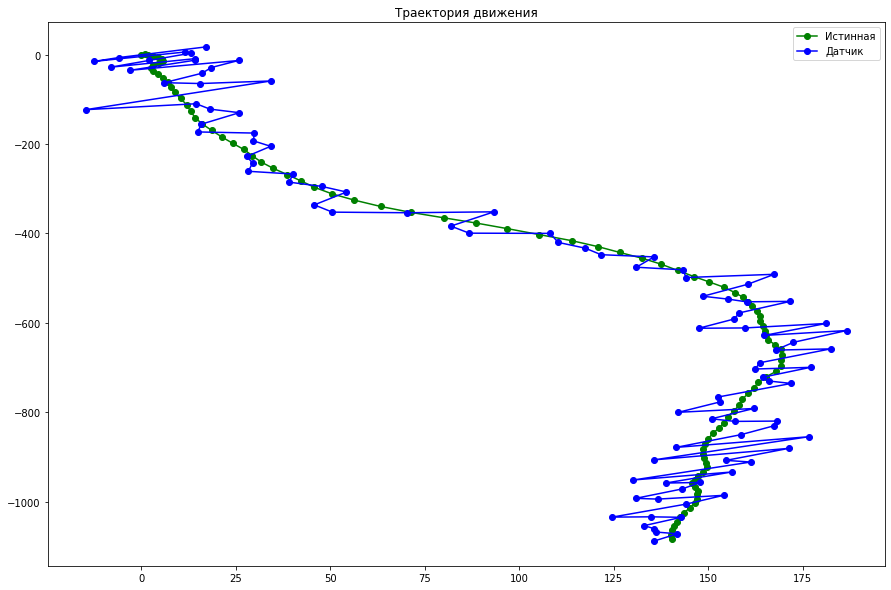

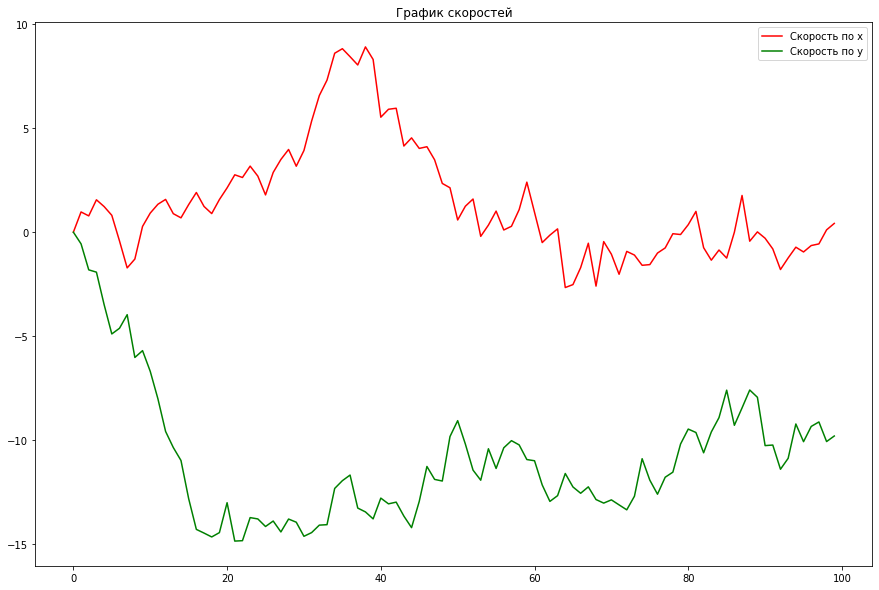

In [6]:
import numpy as np
import numpy.random

def simulate_sensor_2d(num_samples, noise_sigma, acceler_sigma, dt):
    '''
    Моделирует измерения датчика (двумерный случай).
    '''
    
    # Генерируем шум с нормальным распределением
    # (мат. ожидание = 0, среднеквадр. отклонение = noise_sigma):
    noise = np.random.normal(loc=0.0, scale=noise_sigma, size=num_samples)
    
    # Генерируем векторы ускорения с нормальным распределением:
    acceler = np.random.normal(loc=0.0, scale=acceler_sigma, size=(num_samples,2))

    # Опишем траекторию движения при помощи 4 компонент
    # (координата и скорость по осям x и y):
    trajectory = np.zeros((num_samples, 4))
    pos_x, pos_y = 0.0, 0.0                      # координата по x и y
    vel_x, vel_y = 1.0, 1.0                      # скорость по x и y

    # Применяем формулу равноускоренного движения:
    for i in range(1, num_samples):
        pos_x = pos_x + vel_x * dt + (acceler[i-1, 0] * dt ** 2) / 2.0
        pos_y = pos_y + vel_y * dt + (acceler[i-1, 1] * dt ** 2) / 2.0
        vel_x = vel_x + acceler[i-1, 0] * dt
        vel_y = vel_y + acceler[i-1, 1] * dt

        trajectory[i][0] = pos_x
        trajectory[i][1] = vel_x
        trajectory[i][2] = pos_y
        trajectory[i][3] = vel_y

    # Добавляем шум к измерениям датчика:
    measurements = np.zeros((num_samples, 2))
    measurements[:,0] = trajectory[:,0] + noise
    measurements[:,1] = trajectory[:,2] + noise

    return trajectory, measurements         # истинное значение и данные датчика с шумом



### Визуализируем результаты моделирования ###
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

trajectory, measurements = simulate_sensor_2d(num_samples=100, noise_sigma=10, acceler_sigma=1, dt=1)

plt.title("Траектория движения")
plt.plot(trajectory[:,0], trajectory[:,2], 'go-', label='Истинная')
plt.plot(measurements[:,0], measurements[:,1], 'bo-', label='Датчик')
plt.legend()
plt.show()

plt.title("График скоростей")
plt.plot(trajectory[:,1], label="Скорость по x", color='r')
plt.plot(trajectory[:,3], label="Скорость по y", color='g')
plt.legend()
plt.show()

## Применяем фильтр Калмана (двумерный случай)

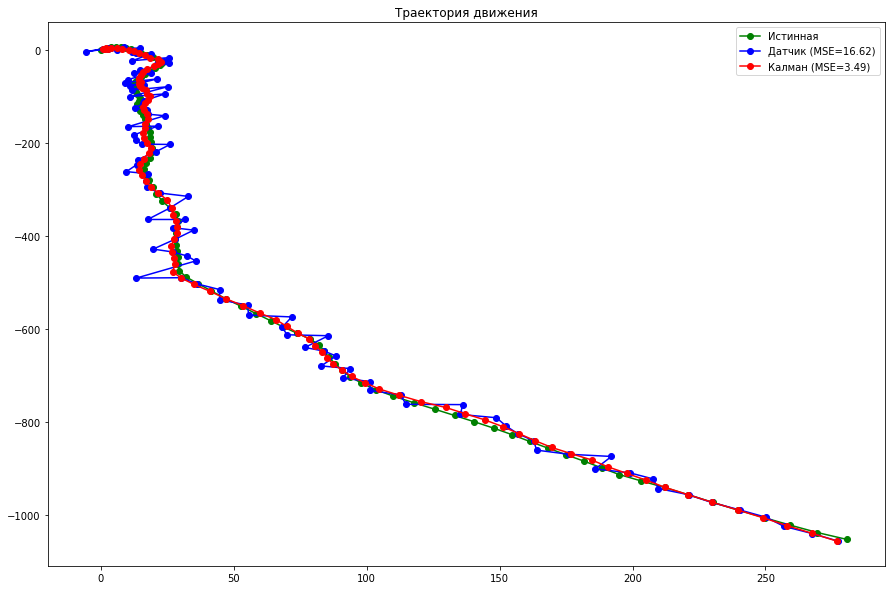

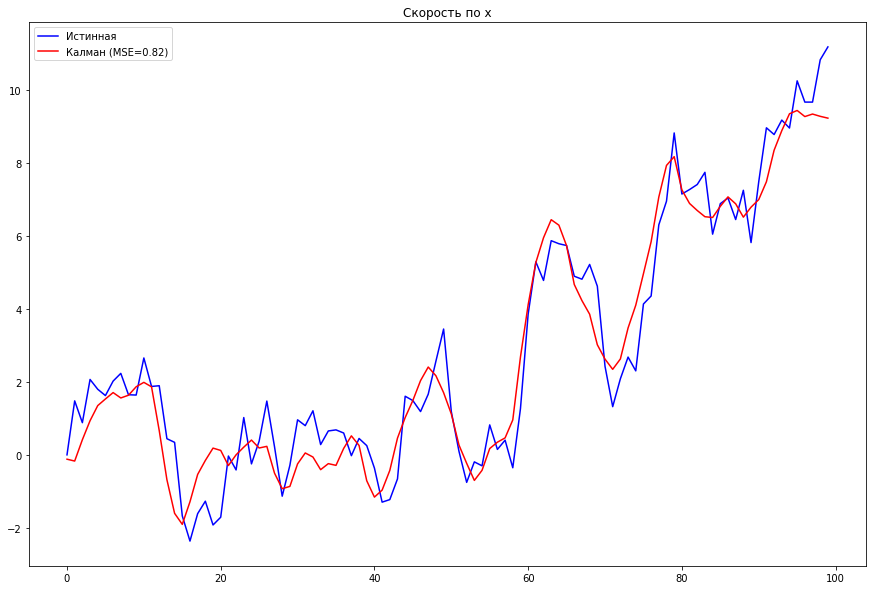

In [11]:
import numpy as np
from pykalman import KalmanFilter


def apply_kalman_2d(measurements, dt=0.01):
    '''
    Применяет фильтр Калмана к заданным измерениям.
    '''
    # Начальное состояние модели:
    initial_state_mean = [measurements[0][0], 0,       # позиция и скорость по x
                          measurements[0][1], 0]       # позиция и скорость по y
    

    # Матрица процесса (state transition matrix):
    transition_mat = [[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]]

    # Матрица наблюдения (obervation matrix):
    observation_mat = [[1, 0, 0, 0,],                   # датчик позиции по x
                       [0, 0, 1, 0]]                    # датчик позиции по y                   

    # Создаем фильтр Калмана с заданными матрицами 
    # процесса, наблюдения и начальным состоянием:
    kf1 = KalmanFilter(transition_matrices=transition_mat,
                       observation_matrices=observation_mat,
                       initial_state_mean=initial_state_mean,
                       em_vars=['transition_covariance', 'initial_state_covariance', 'observation_covariance'])

    # Применяем EM-алгоритм для оценки неизвестных параметров 
    # (в данном примере - для оценки матриц ковариации):
    kf1 = kf1.em(measurements, n_iter=5)
    
    # Применяем фильтр Калмана:
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

    return smoothed_state_means, smoothed_state_covariances


# Моделируем показания датчика:
dt = 1
trajectory, measurements = simulate_sensor_2d(num_samples=100, noise_sigma=5, acceler_sigma=1, dt=dt)

# Применяем фильтр Калмана:
smoothed_trajectory, _ = apply_kalman_2d(measurements, dt=dt)

# MSE:
squared = np.square(smoothed_trajectory - trajectory)
mse_kalman_pos = (squared[:,0].mean() + squared[:,2].mean()) * 0.5
mse_kalman_vel = (squared[:,1].mean() + squared[:,3].mean()) * 0.5
mse_meas_pos = (np.square(smoothed_trajectory[:,0] - measurements[:,0]).mean() + 
                np.square(smoothed_trajectory[:,2] - measurements[:,1]).mean()) * 0.5

# Визуализируем:
plt.title("Траектория движения")
plt.plot(trajectory[:,0], trajectory[:,2], 'go-', 
         label='Истинная')
plt.plot(measurements[:,0], measurements[:,1], 'bo-', 
         label='Датчик (MSE={:.2f})'.format(mse_meas_pos))
plt.plot(smoothed_trajectory[:,0], smoothed_trajectory[:,2], 'ro-', 
         label='Калман (MSE={:.2f})'.format(mse_kalman_pos))
plt.legend()
plt.show()

plt.title("Скорость по x")
plt.plot(trajectory[:,1], color='b', 
         label='Истинная')
plt.plot(smoothed_trajectory[:,1], color='r', 
         label='Калман (MSE={:.2f})'.format(mse_kalman_vel))
plt.legend()
plt.show()

## Интерполяция пропущенных наблюдений

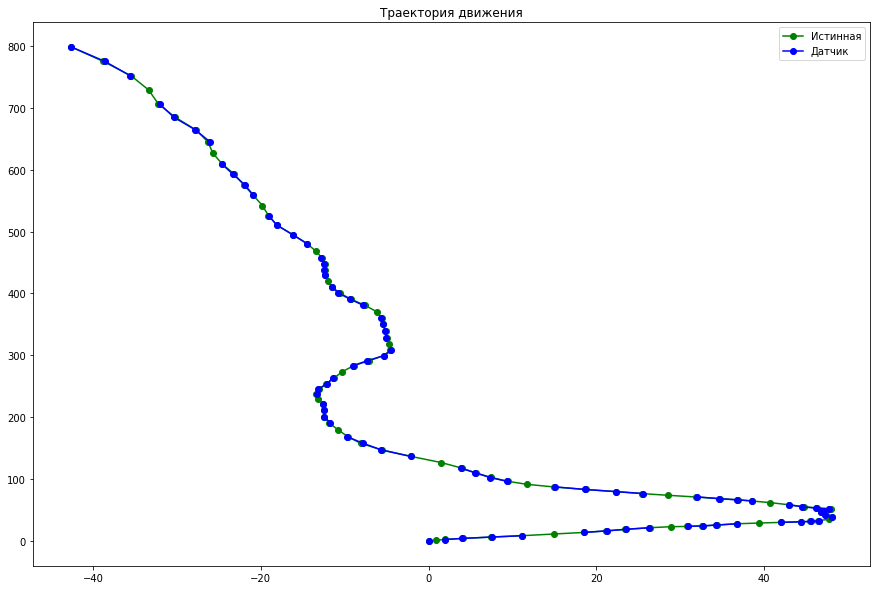

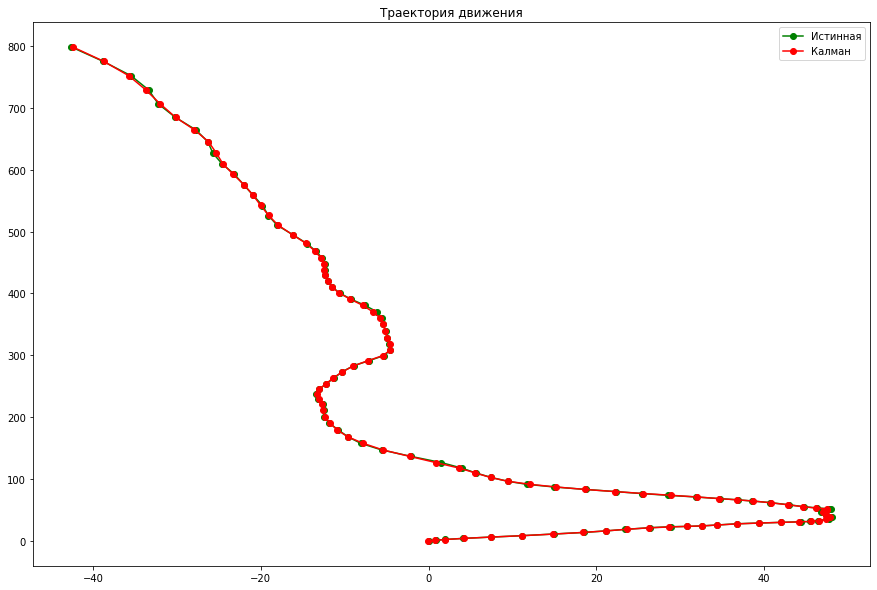

In [32]:
from numpy import ma

# Моделируем показания датчика:
trajectory, measurements = simulate_sensor_2d(num_samples=100, noise_sigma=0.1, acceler_sigma=1, dt=1)

# Маскируем некоторые показания датчика:
measurements = ma.asarray(measurements)
for i in range (1,measurements.shape[0],5):
    measurements[i] = ma.masked

# Применяем фильтр Калмана:
smoothed_trajectory, _ = apply_kalman_2d(measurements, dt=1)

# Визуализируем:
plt.title("Траектория движения")
plt.plot(trajectory[:,0], trajectory[:,2], 'go-', label='Истинная')
plt.plot(measurements[:,0], measurements[:,1], 'bo-', label='Датчик')
plt.legend()
plt.show()

plt.title("Траектория движения")
plt.plot(trajectory[:,0], trajectory[:,2], 'go-', label='Истинная')
plt.plot(smoothed_trajectory[:,0], smoothed_trajectory[:,2], 'ro-', label='Калман')
plt.legend()
plt.show()

___
# Что почитать

1. [Фильтр Калмана — это легко (habr)](https://habr.com/ru/company/singularis/blog/516798/)
2. [Фильтр Калмана (habr)](https://habr.com/ru/post/166693/)
3. [How a Kalman filter works, in pictures](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)
4. [pykalman documentation](https://pykalman.github.io/)
5. [Пример использования пакета pykalman на stackoverflow](https://stackoverflow.com/questions/43377626/how-to-use-kalman-filter-in-python-for-location-data)

In [122]:
def get_init_state_cov(max_velocity):
    # Правило трех сигм: 3*sigma = v_max
    sigma = (max_velocity/3)**2                            
    init_state_cov = np.array([[sigma,     0,     0],
                               [    0, sigma,     0],
                               [    0,     0, sigma]])
    return init_state_cov